<a href="https://colab.research.google.com/github/MrBigBrane/Machine-Learning/blob/main/FFN_Wine_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
### import libraries

# for DL modeling
import torch
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [52]:
### z-score all variables except for quality

# find the columns we want to normalize (all except quality)
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('residual sugar')

# z-score (written out for clarity)
for col in cols2zscore:
  meanval   = np.mean(data[col])
  stdev     = np.std(data[col],ddof=1)
  data[col] = (data[col]-meanval) / stdev

# can also do more compactly
#data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1.599000e+03,1.599000e+03,1.599000e+03,1599.000000,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03
mean,4.088176e-16,1.599721e-16,-8.887339e-17,2.538806,3.554936e-16,-4.443669e-17,3.554936e-17,-3.466062e-14,2.879498e-15,6.754377e-16,8.887339e-17,7.109871e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.409928,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.136377e+00,-2.277567e+00,-1.391037e+00,0.900000,-1.603443e+00,-1.422055e+00,-1.230199e+00,-3.537625e+00,-3.699244e+00,-1.935902e+00,-1.898325e+00,-3.264143e+00
25%,-7.004996e-01,-7.696903e-01,-9.290275e-01,1.900000,-3.711129e-01,-8.484502e-01,-7.438076e-01,-6.075656e-01,-6.549356e-01,-6.380200e-01,-8.661079e-01,-7.875763e-01
50%,-2.410190e-01,-4.367545e-02,-5.634264e-02,2.200000,-1.798892e-01,-1.792441e-01,-2.574163e-01,1.759533e-03,-7.210449e-03,-2.250577e-01,-2.092427e-01,4.507074e-01
75%,5.056370e-01,6.264921e-01,7.650078e-01,2.600000,5.382858e-02,4.899619e-01,4.721707e-01,5.766445e-01,5.757422e-01,4.238832e-01,6.352984e-01,4.507074e-01
max,4.353787e+00,5.876138e+00,3.742403e+00,15.500000,1.112355e+01,5.365606e+00,7.372847e+00,3.678904e+00,4.526866e+00,7.916200e+00,4.201138e+00,2.927275e+00


In [53]:
nanIndices = np.random.randint(0, 1599, size=10)

testData = data.loc[nanIndices,:]

testLabels = torch.tensor(testData['residual sugar'].values, dtype=torch.float32)
testData = torch.tensor(testData.drop('residual sugar',axis=1).values, dtype=torch.float32)
testData

data.drop(nanIndices,inplace=True)
data.reset_index(drop=True,inplace=True)

trainLabels = torch.tensor(data['residual sugar'].values, dtype=torch.float32)
trainData = torch.tensor(data.drop('residual sugar',axis=1).values, dtype=torch.float32)

In [54]:
testLabels = testLabels[:,None]
trainLabels = trainLabels[:,None]

train_data = TensorDataset(trainData,trainLabels)
test_data  = TensorDataset(testData,testLabels)


# finally, translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [55]:
def createTheWineNet():
  class wineNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(11,16)

      ### hidden layers
      self.fc1    = nn.Linear(16,32)
      self.bnorm1 = nn.BatchNorm1d(16) # the number of units into this layer
      self.fc2    = nn.Linear(32,20)
      self.bnorm2 = nn.BatchNorm1d(32) # the number of units into this layer

      ### output layer
      self.output = nn.Linear(20,1)

    # forward pass
    def forward(self,x):

      # input (x starts off normalized)
      x = F.relu( self.input(x) )

      # hidden layer 1
      x = self.bnorm1(x) # batchnorm
      x = self.fc1(x)    # weighted combination
      x = F.relu(x)      # activation function

      # hidden layer 2
      x = self.bnorm2(x) # batchnorm
      x = self.fc2(x)    # weighted combination
      x = F.relu(x)      # activation function

      # output layer
      return self.output(x)

  net = wineNet()

  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [56]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 400

  # create a new model
  net,lossfun,optimizer = createTheWineNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

    # end of batch loop...

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader))
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

  # end epochs

  # function output
  return losses,net

In [57]:
testX, testY = next(iter(train_loader))

net, lossfun, optimizer = createTheWineNet()
yHat = net(testX)
yHat

tensor([[ 0.1117],
        [ 0.3964],
        [ 0.5708],
        [ 0.3867],
        [ 0.8348],
        [ 0.0454],
        [ 0.1462],
        [ 0.0395],
        [ 0.0369],
        [ 0.0571],
        [-0.0922],
        [ 0.1202],
        [ 0.1382],
        [ 0.1240],
        [-0.0515],
        [-0.1114],
        [ 0.3372],
        [ 0.3073],
        [ 0.1589],
        [ 0.0464],
        [ 0.1355],
        [ 0.0315],
        [ 0.0104],
        [-0.0073],
        [ 0.0042],
        [ 0.0254],
        [ 0.2208],
        [ 0.6328],
        [ 0.4226],
        [ 0.0945],
        [ 0.2050],
        [ 0.0877]], grad_fn=<AddmmBackward0>)

In [58]:
losses,net = function2trainTheModel()

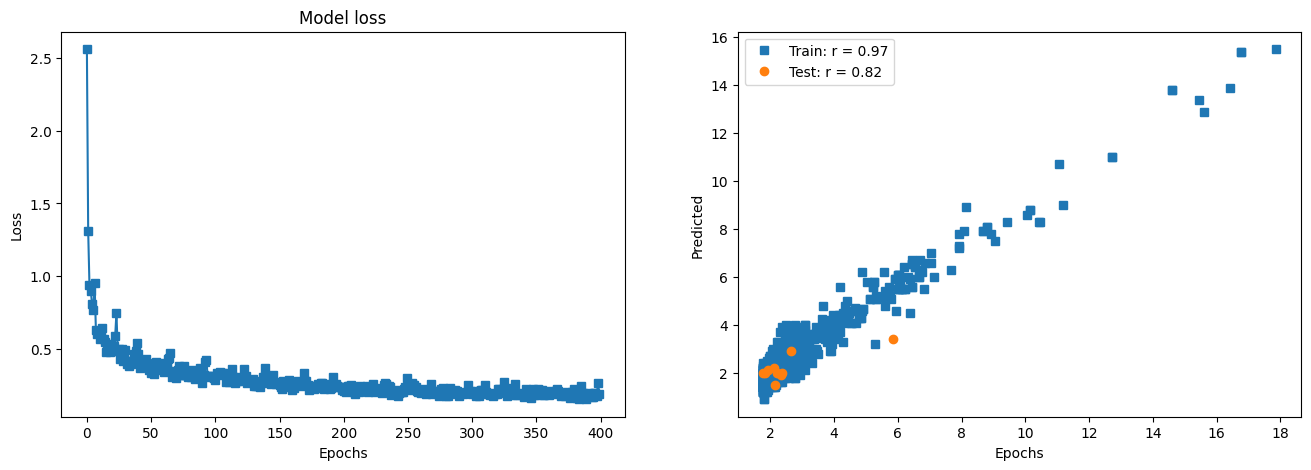

In [73]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

resSugarTrain = net(trainData)
resSugarTest  = net(testData)

rtrain, ptrain = stats.pearsonr(resSugarTrain.detach().numpy().flatten(), trainLabels.detach().numpy().flatten())
rtest, ptest = stats.pearsonr(resSugarTest.detach().numpy().flatten(), testLabels.detach().numpy().flatten())

ax[0].plot(losses,'s-',label='Train')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(resSugarTrain.detach().numpy(),trainLabels.detach().numpy(),'s',label=(f'Train: r = {rtrain:.2f}'))
ax[1].plot(resSugarTest.detach().numpy(),testLabels.detach().numpy(),'o',label=(f'Test: r = {rtest:.2f}'))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Predicted')
# ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()